# Importing required Libraries

In [1]:
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from scipy import signal
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

# Importing Files

In [2]:
pwd

'/Users/ad/Downloads/FYP'

In [3]:
mypath ='/Users/ad/Downloads/FYP/audio_and_txt_files/'
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

In [4]:
type(filenames)

list

In [5]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

# Creating functions for data Augmentation

In [6]:
def shift(data, shift_max=2, shift_direction='right'):
    shift = np.random.randint(22050 * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif self.shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    audio, sample_rate = librosa.load(data, res_type='kaiser_fast', duration=20) 
    b, a = signal.butter(6, [100/sample_rate,5000/sample_rate], 'bandpass', analog=False)
    f = signal.filtfilt(b, a, audio)
    augmented_data = np.roll(f, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    mfccs = librosa.feature.mfcc(y=augmented_data, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    return mfccs

In [7]:
def pitch(data, pitch_factor=2):
    audio, sample_rate = librosa.load(data, res_type='kaiser_fast', duration=20) 
    audio=librosa.effects.pitch_shift(audio, sample_rate, pitch_factor)
    b, a = signal.butter(6, [100/sample_rate,5000/sample_rate], 'bandpass', analog=False)
    f = signal.filtfilt(b, a, audio)
    mfccs = librosa.feature.mfcc(y=f, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfccs

In [8]:
def speed(data, speed_factor=2):
    audio, sample_rate = librosa.load(data, res_type='kaiser_fast', duration=20)
    audio=librosa.effects.time_stretch(audio, speed_factor)
    b, a = signal.butter(6, [100/sample_rate,5000/sample_rate], 'bandpass', analog=False)
    f = signal.filtfilt(b, a, audio)
    mfccs = librosa.feature.mfcc(y=f, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfccs

In [9]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        b, a = signal.butter(6, [100/sample_rate,5000/sample_rate], 'bandpass', analog=False)
        f = signal.filtfilt(b, a, audio)
        mfccs = librosa.feature.mfcc(y=f, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [10]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [11]:
p_diag = pd.read_csv('/Users/ad/Downloads/FYP/patient_diagnosis.csv',header=None) # patient diagnosis file

In [12]:
test_patients=p_diag.sample(n=20)

In [13]:
test_filenames=[]
for item in filenames:
    if int(item[:3])in test_patients[0].values:
        test_filenames.append(item)

In [14]:
filepaths_test=[join(mypath, f) for f in test_filenames]

In [15]:
p_id_in_test = [] # patient IDs corresponding to each file
for name in test_filenames:
    p_id_in_test.append(int(name[:3]))

p_id_in_test = np.array(p_id_in_test)

In [16]:
train_patients=p_diag[~p_diag.index.isin(test_patients.index)]

In [17]:
train_filenames=[]
for item in filenames:
    if int(item[:3])in train_patients[0].values:
        train_filenames.append(item)

In [18]:
filepaths_train=[join(mypath, f) for f in train_filenames]

In [19]:
p_id_in_train = [] # patient IDs corresponding to each file
for name in train_filenames:
    p_id_in_train.append(int(name[:3]))

p_id_in_train = np.array(p_id_in_train)

In [20]:
labels_test = np.array([test_patients[test_patients[0] == x][1].values[0] for x in p_id_in_test]) # labels for audio files

In [21]:
len(labels_test)

151

In [22]:
labels_train = np.array([train_patients[train_patients[0] == x][1].values[0] for x in p_id_in_train]) # labels for audio files

In [23]:
len(labels_train)

769

# Extracting Features

In [24]:
features_test = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths_test:
    data = extract_features(file_name)
    features_test.append(data)

print('Finished feature extraction from ', len(features_test), ' original files')
features_train = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths_train:
    data = extract_features(file_name)
    features_train.append(data)

print('Finished feature extraction from ', len(features_train), ' original files')

Finished feature extraction from  151  original files
Finished feature extraction from  769  original files


# Adding Augmented Files to data set

In [25]:
labels_test=np.array(labels_test).tolist()
for i in range (0,len(labels_test)):
    if labels_test[i]!='COPD':
        p=shift(filepaths_test[i], 2, 'right')
        q=pitch(filepaths_test[i],2)
        r=speed(filepaths_test[i],1.2)
        features_test.append(p)
        features_test.append(q)
        features_test.append(r)
        for j in range(0,3):
            labels_test.append(labels_test[i])

labels_train=np.array(labels_train).tolist()
for i in range (0,len(labels_train)):
    if labels_train[i]!='COPD':
        p=shift(filepaths_train[i], 2, 'right')
        q=pitch(filepaths_train[i],2)
        r=speed(filepaths_train[i],1.2)
        features_train.append(p)
        features_train.append(q)
        features_train.append(r)
        for j in range(0,3):
            labels_train.append(labels_train[i])

In [26]:
features_test=np.array(features_test)
features_train=np.array(features_train)
labels_test=np.array(labels_test)
labels_train=np.array(labels_train)

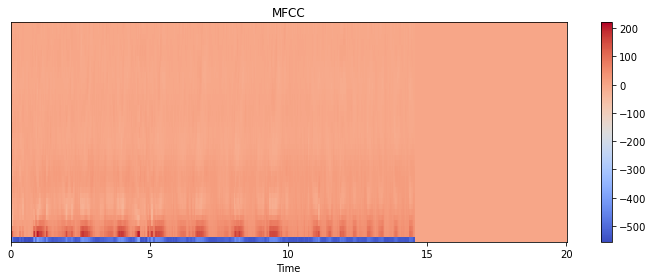

In [27]:
#plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features_train[1], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

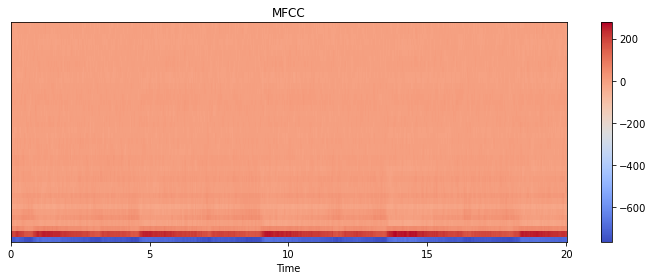

In [28]:
#plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features_test[1], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [29]:
# print class counts
unique_elements, counts_elements = np.unique(labels_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI'
  'Pneumonia' 'URTI']
 ['4' '52' '52' '660' '100' '8' '132' '88']]


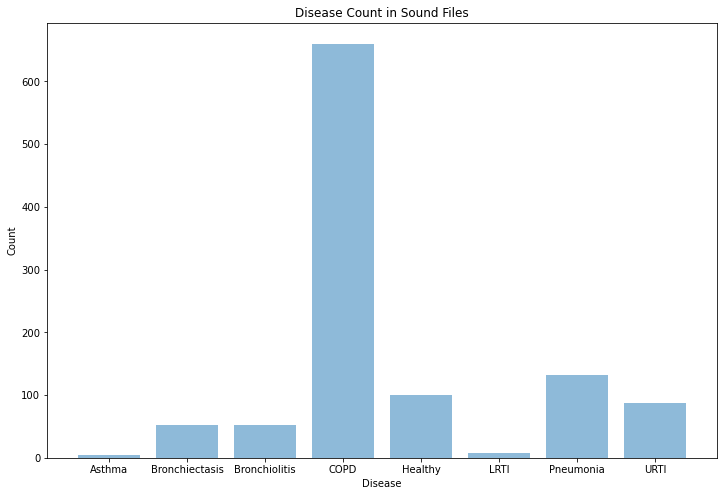

In [30]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

In [31]:
unique_elements, counts_elements = np.unique(labels_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['12' '133' '40' '16' '4']]


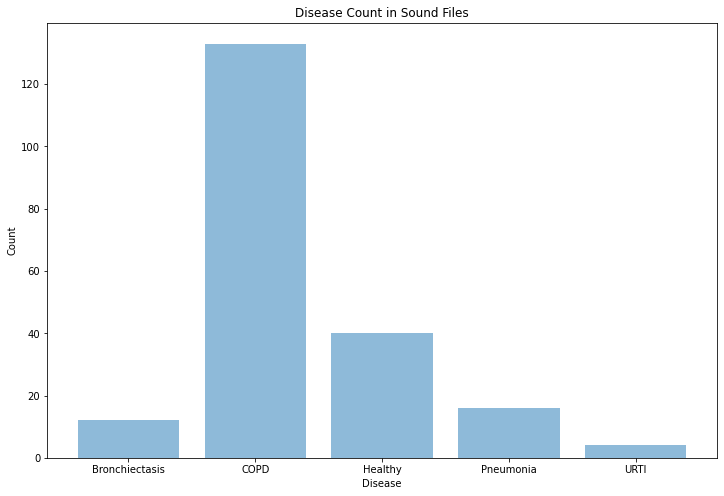

In [32]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

# Remove the data with least cases

In [33]:
features1_train = np.delete(features_train, np.where((labels_train == 'Asthma') | (labels_train == 'LRTI'))[0], axis=0) 
labels1_train = np.delete(labels_train, np.where((labels_train == 'Asthma') | (labels_train == 'LRTI'))[0], axis=0)

features1_test = np.delete(features_test, np.where((labels_test == 'Asthma') | (labels_test == 'LRTI'))[0], axis=0) 
labels1_test = np.delete(labels_test, np.where((labels_test == 'Asthma') | (labels_test == 'LRTI'))[0], axis=0)

# Designing Neural Network

In [34]:
# One-hot encode labels
le = LabelEncoder()
i_labels_train = le.fit_transform(labels1_train)
i_labels_train=np.array(i_labels_train).tolist()

i_labels_test = le.fit_transform(labels1_test)
i_labels_test=np.array(i_labels_test).tolist()


In [35]:
for i in range(0,len(i_labels_test)):
    if i_labels_test[i] ==2:
        i_labels_test[i]= 0
    elif i_labels_test[i]==3:
        i_labels_test[i]= 1
    else:
        i_labels_test[i]=2

for i in range(0,len(i_labels_train)):
    if i_labels_train[i] ==2:
        i_labels_train[i]= 0
    elif i_labels_train[i]==3:
        i_labels_train[i]= 1
    else:
        i_labels_train[i]=2


In [36]:
i_labels_test=np.array(i_labels_test)
i_labels_train=np.array(i_labels_train)
oh_labels_test = to_categorical(i_labels_test)
oh_labels_train = to_categorical(i_labels_train)

In [37]:
oh_labels_train[0]

array([0., 0., 1.], dtype=float32)

In [38]:
# add channel dimension for CNN
features1_test = np.reshape(features1_test, (*features1_test.shape,1))
features1_train = np.reshape(features1_train, (*features1_train.shape,1))

In [39]:
# train test split
x_train, x_test, y_train, y_test = features1_train,features1_test,oh_labels_train,oh_labels_test

In [40]:
y_train[0]

array([0., 0., 1.], dtype=float32)

In [48]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels_test.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=96, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(filters=96, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(Dropout(0.6))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.15))
model.add(Dense(32))
model.add(Dropout(0.075))
model.add(Dense(16))
model.add(Dropout(0.0325))
model.add(Dense(8))
model.add(Dense(num_labels, activation='softmax'))

In [49]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [50]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 39, 861, 64)       320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 430, 64)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 429, 64)       16448     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 214, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 213, 96)        24672     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 106, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 105, 96)       

# Training the model

In [ ]:
# train model
num_epochs = 120
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/120
9/9 [==============================] - 19s 2s/step - loss: 5.3554 - accuracy: 0.4862 - val_loss: 1.4402 - val_accuracy: 0.1854

Epoch 00001: val_accuracy improved from -inf to 0.18537, saving model to mymodel2_01.h5
Epoch 2/120
9/9 [==============================] - 20s 2s/step - loss: 0.9851 - accuracy: 0.6015 - val_loss: 1.3550 - val_accuracy: 0.1610

Epoch 00002: val_accuracy did not improve from 0.18537
Epoch 3/120
9/9 [==============================] - 19s 2s/step - loss: 0.7142 - accuracy: 0.6725 - val_loss: 1.4258 - val_accuracy: 0.1707

Epoch 00003: val_accuracy did not improve from 0.18537
Epoch 4/120
9/9 [==============================] - 20s 2s/step - loss: 0.6567 - accuracy: 0.7011 - val_loss: 1.7809 - val_accuracy: 0.1366

Epoch 00004: val_accuracy did not improve from 0.18537
Epoch 5/120
9/9 [==============================] - 20s 2s/step - loss: 0.5862 - accuracy: 0.7445 - val_loss: 2.4205 - val_accuracy: 0.1171

Epoch 00005: val_accuracy did not improve from 

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

In [ ]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=3 # number of classes

# Summarize History for Loss

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize History for accuracy

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
c_names2=["Chronic",'Healthy','Non Chronic']

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names2[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names2))

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))